In [18]:
import pandas as pd
import numpy as np
from pyDeepInsight import ImageTransformer
from pyDeepInsight.feature_selection import CAMFeatureSelector
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset, Subset
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from torchscripts.torch_train import *
from torchscripts.classifiers import *
from math import ceil, sqrt
from collections import Counter
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import umap.umap_ as umap
import re
import warnings
warnings.simplefilter('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
data = pd.read_csv('./data/species_asin0.csv', index_col=0 )
le = LabelEncoder()
y= le.fit_transform(data['y'])
y = y.reshape(-1) 

In [20]:
species_values = [col.split('_')[2] if len(col.split('_')) > 1 else col for col in data.columns]
annotated_res = pd.read_csv('./data/annotated_species.csv', index_col=0)
current_df= annotated_res[annotated_res["Species"].isin(species_values)]
transposed_df = current_df.set_index('Species').T

In [21]:
metabs = pd.read_csv('./data/metabolites.csv', index_col=0)
transposed_df = metabs.T
transposed_df.rename(columns=lambda x: re.sub(r'\W+', '', x), inplace=True)
common_cols = set(transposed_df.columns) & set(species_values)
current_df = transposed_df[list(common_cols)]
column_sums = current_df.sum(axis=0)
filtered_sums = column_sums.loc[column_sums != 0]

In [22]:
X = data.drop('y', axis=1)

missing_cols = set(X.columns) - set(current_df.columns) 
for col in missing_cols:
    current_df[col] = 0

current_df= current_df[X.columns]
combined_df = pd.concat([current_df,X])

In [23]:
data = pd.read_csv('./data/species_asin0.csv', index_col=0 )
data.index = data.index.str.replace('^X', '', regex=True)
img_data= pd.read_csv('./data/species_asin_nophylum.csv', index_col=0 )
img_data['y'] = img_data['y'].str.extract('(\d)').astype(int)

In [24]:
import re
def clean_index(index):
    return re.sub('[^a-zA-Z0-9]', '', index)

# Clean the index values in df1
data.index = data.index.map(clean_index).str.lower()

# Clean the index values in df2
img_data.index = img_data.index.map(clean_index).str.lower()

In [25]:
X_nophy = data.drop(data.index[-1])
X_nophy['y'] = X_nophy['y'].str.extract('(\d)').astype(int)

In [26]:
common_index = X_nophy.index.intersection(img_data.index)
len(common_index)
# # # Reindex both DataFrames based on the common row names
img_data = img_data.reindex(common_index)
X_nophy  = X_nophy.reindex(common_index)

In [27]:
y_phy = X_nophy['y']
le = LabelEncoder()
le = le.fit(y_phy) 
y_phy = le.transform(y_phy)
X_noy = data.drop('y',axis=1)
dataset = PhylumDataset(X_noy, y_phy)

In [28]:

y_img= le.transform(img_data['y'])
y_img_np = y_img.reshape(-1) 

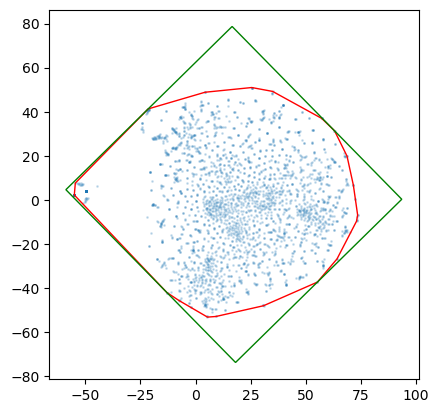

In [29]:
X_img = img_data.drop('y', axis=1)
metabs = pd.read_csv('./data/metabolites.csv', index_col=0)
transposed_df = metabs.T
transposed_df.rename(columns=lambda x: re.sub(r'\W+', '', x), inplace=True)
common_cols = set(transposed_df.columns) & set(species_values)
current_df = transposed_df[list(common_cols)]
missing_cols = set(X_img.columns) - set(current_df.columns) 
for col in missing_cols:
    current_df[col] = 0

# reordercol for concat

current_df= current_df[X_img.columns]
combined_df = pd.concat([current_df,X_img])
#combined_df = X_img
isize=60
reducer_tsne = TSNE(n_components=2,metric="braycurtis", n_jobs=32,perplexity = 50, early_exaggeration=20, learning_rate=100)
it = ImageTransformer(pixels=(isize,isize), feature_extractor= reducer_tsne )
it.fit(combined_df, y=y_img, plot=True)
X_img_transformed= it.transform(X_img)[:, :, :, 0]

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

rf_params = {
    'n_estimators': [50, 200],
    'max_depth': [None, 10, 30]
}

svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'probability': [True]
}
X_tab = X_nophy.drop(['y'],axis=1)
#Subset of dataset to save time, if you wish to use full remove below line
subset_fraction = 0.5
subset_indices = np.random.choice(X_tab.shape[0], size=int(subset_fraction * X_tab.shape[0]), replace=False)

# One-liner to get a random subset for X and corresponding y
X_subset, y_subset = X_tab.iloc[subset_indices].values, y_phy[subset_indices]
# Create the models
rf_model = RandomForestClassifier()
svm_model = SVC()

# Grid search for Random Forest
rf_grid_search = GridSearchCV(rf_model, rf_params, cv=5)
rf_grid_search.fit(X_subset, y_subset)

# Grid search for SVM
svm_grid_search = GridSearchCV(svm_model, svm_params, cv=5)
svm_grid_search.fit(X_subset, y_subset)

# Get the best models
best_rf_model = rf_grid_search.best_estimator_
best_svm_model = svm_grid_search.best_estimator_


In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import random

preprocess = transforms.Compose([
    transforms.ToTensor()
])

#Filters, Kernel Size, Stride
resblocks_params = [[16, 3, 1], [32, 3, 2]]
big_acc = []
X_full_img_tensor = torch.stack([preprocess(img) for img in X_img_transformed]).to(device).float()
y_img  = torch.from_numpy(y_img_np )
for rep in range(5):
    skf = StratifiedKFold(n_splits=5, random_state=random.randint(1,1000), shuffle=True)

    for train_temp_indices, test_indices in skf.split(X_img_transformed, y_img ):
        print(rep)
        train_indices, valid_indices = train_test_split(train_temp_indices, test_size=0.25, random_state=21, stratify=y_img[train_temp_indices])
        train_dataset_tab = Subset(dataset, train_indices)  # assuming `dataset` is your first dataset
        valid_dataset_tab = Subset(dataset, valid_indices)
        test_dataset_tab = Subset(dataset, test_indices)

        # Subset for second dataset
        X_train2 = X_full_img_tensor[train_indices]
        y_train2 = y_img [train_indices]
        train_dataset2 = TensorDataset(X_train2, y_train2)

        X_valid2 = X_full_img_tensor[valid_indices]
        y_valid2 = y_img [valid_indices]
        valid_dataset2 = TensorDataset(X_valid2, y_valid2)

        X_test2 = X_full_img_tensor[test_indices]
        y_test2 = y_img [test_indices]
        test_dataset2 = TensorDataset(X_test2, y_test2)

        # Create dataloaders
        train_dataloader_tab = DataLoader(train_dataset_tab, batch_size=32, shuffle=True)
        valid_dataloader_tab = DataLoader(valid_dataset_tab, batch_size=32, shuffle=True)
        test_dataloader_tab = DataLoader(test_dataset_tab, batch_size=32, shuffle=True)

        train_dataloader_img = DataLoader(train_dataset2, batch_size=32, shuffle=True)
        valid_dataloader2_img= DataLoader(valid_dataset2, batch_size=32, shuffle=True)
        test_dataloader2_img = DataLoader(test_dataset2, batch_size=32, shuffle=True)

        X_train_rf_svm = X_tab.iloc[train_indices]
        y_train_rf_svm = y_phy[train_indices]
    
        X_test_rf_svm = X_tab.iloc[test_indices]
        y_test_rf_svm = y_phy[test_indices]

        # RF Model
        best_rf_model = rf_grid_search.best_estimator_
        best_rf_model.fit(X_train_rf_svm, y_train_rf_svm)
        rf_predictions = best_rf_model.predict(X_test_rf_svm)
        rf_probabilities = best_rf_model.predict_proba(X_test_rf_svm)
        rf_accuracy = accuracy_score(y_test_rf_svm, rf_predictions)

        # SVM Model
        best_svm_model = svm_grid_search.best_estimator_
        best_svm_model.fit(X_train_rf_svm, y_train_rf_svm)
        svm_predictions = best_svm_model.predict(X_test_rf_svm)
        svm_probabilities = best_svm_model.predict_proba(X_test_rf_svm)
        svm_accuracy = accuracy_score(y_test_rf_svm, svm_predictions)

        for model_name, predictions, probabilities in zip(['RF', 'SVM'], [rf_predictions, svm_predictions], [rf_probabilities, svm_probabilities]):
            # get metrics
            acc = accuracy_score(y_test_rf_svm, predictions)
            ba = balanced_accuracy_score(y_test_rf_svm, predictions)
            auc_score = roc_auc_score(y_test_rf_svm, probabilities[:, 1])  # get probabilities of positive class
            f1 = f1_score(y_test_rf_svm, predictions)

            #Create dictionary with all metrics and then pass to df 
            accs = {'Train': model_name, 'Acc': acc, 'Bacc': ba, 'AUC': auc_score, 'F1': f1}
            print(f'Model: {model_name}, Acc: {acc:.2f}, BAcc: {ba:.2f}, F1: {f1:.2f}, AUC: {auc_score:.2f}')
            acc_df = pd.DataFrame(data=accs, index=[0])
            big_acc.append(acc_df)

        encoders = {}
        for groups in dataset.groups:
            input_size = dataset.grouped_data[groups].shape[1]
            encoders[groups] = TaxoNNsub(input_size).to(device)
        num_labels = 2
        taxonn =TaxoNN(encoders,num_labels)
        taxonn.to(device)
        #cnn= nn.DataParallel(cnn)
        criterion = nn.CrossEntropyLoss()
        opt_taxonn=   optim.Adam(taxonn.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001)
        best_taxo = train_best_taxonn(taxonn, num_labels, dataset, device, criterion, opt_taxonn , train_dataloader_tab, valid_dataloader_tab,500,150)
        results_taxo = collect_taxonn_bin(best_taxo,device,test_dataloader_tab, 'TaxoNN')
        big_acc.append(results_taxo)

        #deeplast
        fname = "best_model_" + "deeplast" + ".pth"
        mod = ResClass(isize, resblocks_params)
        mod.to(device)

        opt_impact =   optim.Adam(mod.parameters(),  lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001)    
        results = train_best_image(mod,  device, criterion, opt_impact, train_dataloader_img , test_dataloader2_img,1000,250,fname)
        impact = ResClass(isize, resblocks_params)
        impact.load_state_dict(torch.load(fname))
        results = collect_dlmetrics_bin(impact,device,X_test2, y_test2, fname)
        big_acc.append(results)
            

0
Model: RF, Acc: 0.70, BAcc: 0.66, F1: 0.78, AUC: 0.73
Model: SVM, Acc: 0.66, BAcc: 0.64, F1: 0.73, AUC: 0.71
Saving the best model (Epoch: 1, Validation Accuracy: 0.5791)...
Early stopping triggered. No improvement in validation accuracy for 150 consecutive epochs.
Model: TaxoNN 	Acc: 0.58 	BAcc: 0.50 F1: 0.73 	AUC: 0.55
Saving the best model (Epoch: 1, Validation Accuracy: 0.5791)...
Saving the best model (Epoch: 3, Validation Accuracy: 0.5827)...
Saving the best model (Epoch: 4, Validation Accuracy: 0.5863)...
Saving the best model (Epoch: 5, Validation Accuracy: 0.6115)...
Saving the best model (Epoch: 14, Validation Accuracy: 0.6151)...
Saving the best model (Epoch: 19, Validation Accuracy: 0.6187)...
Saving the best model (Epoch: 22, Validation Accuracy: 0.6367)...
Saving the best model (Epoch: 26, Validation Accuracy: 0.6403)...
Saving the best model (Epoch: 29, Validation Accuracy: 0.6583)...
Saving the best model (Epoch: 39, Validation Accuracy: 0.6691)...
Saving the best mod

KeyboardInterrupt: 

In [ ]:
results_binary = pd.concat(big_acc)
results_binary.to_csv('bin_results.csv', encoding='utf-8', index=False)